In [1]:
import numpy as np
import mne
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
import dynsys_reservoir as dynsys
import seaborn as sns
from matplotlib import pyplot as plt
import PRA as pra

### Fixing parameters

In [2]:
sfreq = 100 # Hz
tmin = 0 # s
tmax = 100 # s
time = np.arange(tmin, tmax, 1/sfreq) 

c_1_2 = 1
c_3_1 = 1
c_3_2 = 1

f1 = 0.125
f2 = 0.25
f3 = 0.10

signal1 = np.sin(2*np.pi*f1*time)
signal2 = np.sin(2*np.pi*f2*time)
signal3 = np.sin(2*np.pi*f3*time)

snr1 = 0.1
snr2 = 0.1
snr3 = 0.1

noise1 = np.random.randn(len(time))
noise2 = np.random.randn(len(time))
noise3 = np.random.randn(len(time))

phase_1 = 0.50*np.pi
phase_2 = 0.75*np.pi
phase_3 = 0.25*np.pi

lag1 = np.int64((phase_1/(2*np.pi)*sfreq))
lag2 = np.int64((phase_2/(2*np.pi)*sfreq))
lag3 = np.int64((phase_3/(2*np.pi)*sfreq))

### Scenario 1 B

In [3]:
y3 = signal3 + noise3*snr3 
y1 = signal1 + noise1*snr1 + c_3_1*np.roll(y3, lag1)
y2 = signal2 + noise2*snr2 + c_3_2*np.roll(y3, lag2) + c_1_2*np.roll(y1, lag3)

#### Simulated data and estimations

In [9]:
## simulated data
sim_data = np.array([y1,y2,y3])
info = mne.create_info(ch_names=["y1", "y2", "y3"], ch_types=["eeg"]*3, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=10)

## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)
dynsys_mat = (dynsys_mat - dynsys_mat.min())/(dynsys_mat.max() - dynsys_mat.min())

#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")
coh_mat = (coh_mat - coh_mat.min())/(coh_mat.max() - coh_mat.min())

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")
ciplv_mat = (ciplv_mat - ciplv_mat.min())/(ciplv_mat.max() - ciplv_mat.min())

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
gpdc_mat = (gpdc_mat - gpdc_mat.min())/(gpdc_mat.max() - gpdc_mat.min())

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
ddtf_mat = (ddtf_mat - ddtf_mat.min())/(ddtf_mat.max() - ddtf_mat.min())

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
psgp_mat = (psgp_mat - psgp_mat.min())/(psgp_mat.max() - psgp_mat.min())

#pra
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
pra_mat = pra.PRA(epochs.get_data())
pra_mat = (pra_mat - pra_mat.min())/(pra_mat.max() - pra_mat.min())

Creating RawArray with float64 data, n_channels=3, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 1000 original time points ...
0 bad epochs dropped


  0%|          | 0/10 [00:00<?, ?it/s]

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..9.990s for estimation (1000 points)
    frequencies: 8.0Hz..13.0Hz (51 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.

Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged


Using data from preloaded Raw for 10 events and 1000 original time points ...


Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged


Using data from preloaded Raw for 10 events and 1000 original time points ...


Maximum iterations reached. 0 of 1 converged


Using data from preloaded Raw for 10 events and 1000 original time points ...


  0%|          | 0/10 [00:00<?, ?it/s]

#### Adjacency matrices

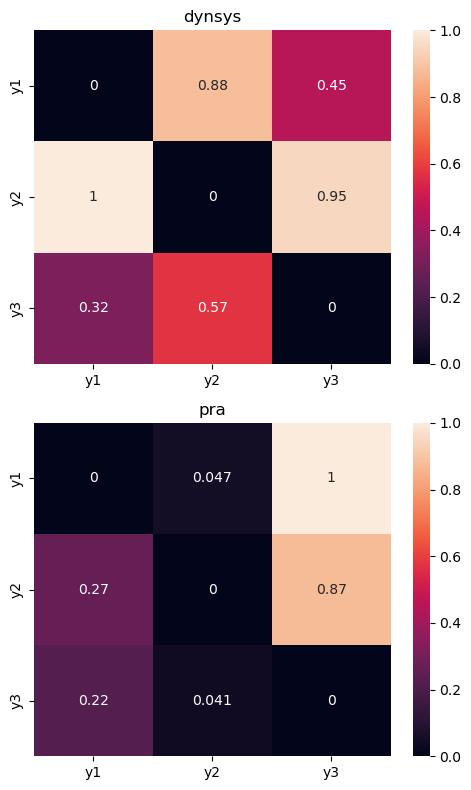

In [6]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5,8))
sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('dynsys')

sns.heatmap(pra_mat, annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('pra')

fig.tight_layout()
plt.savefig('heatmaps.png')

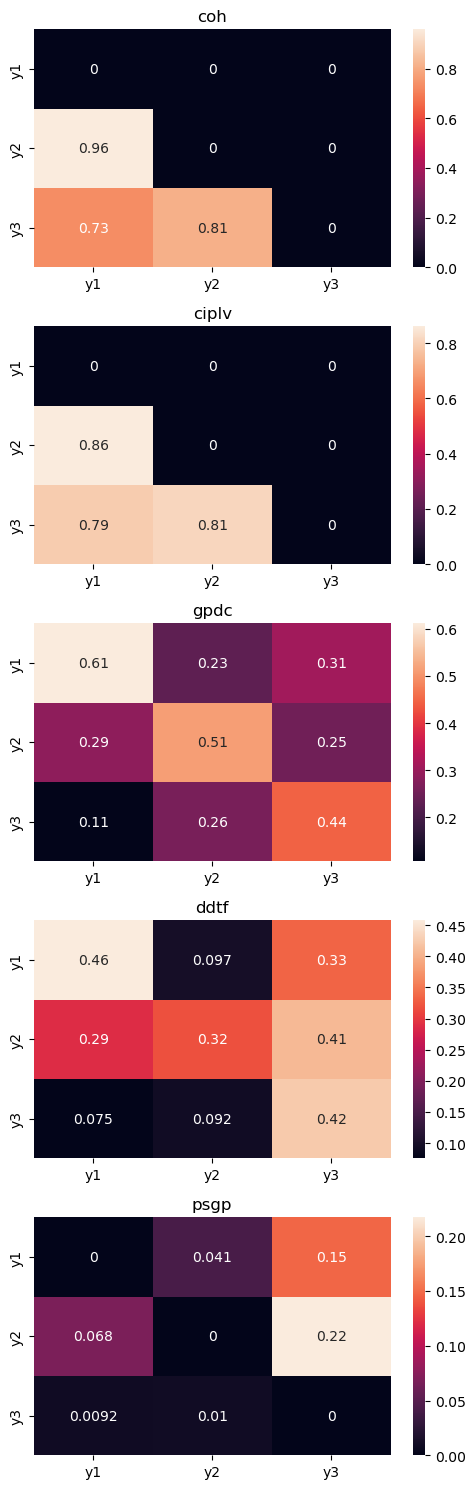

In [7]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(5,15))
sns.heatmap(coh_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('coh')

sns.heatmap(ciplv_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('ciplv')

sns.heatmap(gpdc_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax3)
ax3.set_title('gpdc')

sns.heatmap(ddtf_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax4)
ax4.set_title('ddtf')

sns.heatmap(psgp_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax5)
ax5.set_title('psgp')
fig.tight_layout()
plt.savefig('heatmaps.png')

#### Assessing all connections with mse

In [40]:
ground_truth = np.array([[0,0,1],[1,0,1],[0,0,0]])

mse_dynsys = np.sum((dynsys_mat - ground_truth)**2)/9
mse_pra = np.sum((pra_mat - ground_truth)**2)/9
mse_coh = np.sum((coh_mat.mean(2) - ground_truth)**2)/6
mse_ciplv = np.sum((ciplv_mat.mean(2) - ground_truth)**2)/6
mse_gpdc = np.sum((gpdc_mat.mean(2) - ground_truth)**2)/9
mse_ddtf = np.sum((ddtf_mat.mean(2) - ground_truth)**2)/9
mse_psgp = np.sum((psgp_mat.mean(2) - ground_truth)**2)/9

mse_dict = {'dynsys': mse_dynsys, 'pra':mse_pra, 'coh':mse_coh, 'ciplv':mse_ciplv, 'gpdc':mse_gpdc, 'ddtf':mse_ddtf,
            'psgp':mse_psgp}

In [41]:
sorted(mse_dict.items(), key=lambda x:x[1])

[('pra', 0.05114198026755946),
 ('dynsys', 0.11433766770717549),
 ('psgp', 0.16832238970818209),
 ('ddtf', 0.20419088272568495),
 ('gpdc', 0.28863213137978566),
 ('coh', 0.5338640127184),
 ('ciplv', 0.5678913810588887)]

#### Assessing y1-y2 connection only

<BarContainer object of 8 artists>

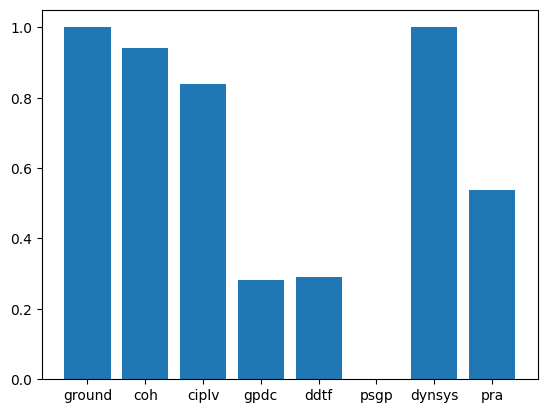

In [44]:
measures = ['ground', 'coh', 'ciplv', 'gpdc', 'ddtf', 'psgp', 'dynsys', 'pra']
y1_y2 = [1, coh_mat.mean(2)[1][0], ciplv_mat.mean(2)[1][0], gpdc_mat.mean(2)[1][0], ddtf_mat.mean(2)[1][0], psgp_mat.mean(2)[1][0],
        dynsys_mat.squeeze()[1][0], pra_mat.squeeze()[1][0]]
plt.bar(measures, y1_y2)

### Scenario 1A

In [45]:
y3 = signal3 + noise3*snr3 
y1 = signal1 + noise1*snr1 + c_3_1*np.roll(y3, lag1)
y2 = signal2 + noise2*snr2 + c_3_2*np.roll(y3, lag2)

#### simulated data and estimations

In [46]:
## simulated data
sim_data = np.array([y1,y2,y3])
info = mne.create_info(ch_names=["y1", "y2", "y3"], ch_types=["eeg"]*3, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=10)

## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)
dynsys_mat = (dynsys_mat - dynsys_mat.min())/(dynsys_mat.max() - dynsys_mat.min())

#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")
coh_mat = (coh_mat - coh_mat.min())/(coh_mat.max() - coh_mat.min())

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")
ciplv_mat = (ciplv_mat - ciplv_mat.min())/(ciplv_mat.max() - ciplv_mat.min())

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
gpdc_mat = (gpdc_mat - gpdc_mat.min())/(gpdc_mat.max() - gpdc_mat.min())

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
ddtf_mat = (ddtf_mat - ddtf_mat.min())/(ddtf_mat.max() - ddtf_mat.min())

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
psgp_mat = (psgp_mat - psgp_mat.min())/(psgp_mat.max() - psgp_mat.min())

#pra
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
pra_mat = pra.PRA(epochs.get_data(), epoch_idx, region, sampling_time=0.01)
pra_mat = (pra_mat - pra_mat.min())/(pra_mat.max() - pra_mat.min())

Creating RawArray with float64 data, n_channels=3, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 1000 original time points ...
0 bad epochs dropped


  0%|          | 0/1 [00:00<?, ?it/s]

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..9.990s for estimation (1000 points)
    frequencies: 8.0Hz..13.0Hz (51 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.

  0%|          | 0/10 [00:00<?, ?it/s]

#### heatmaps

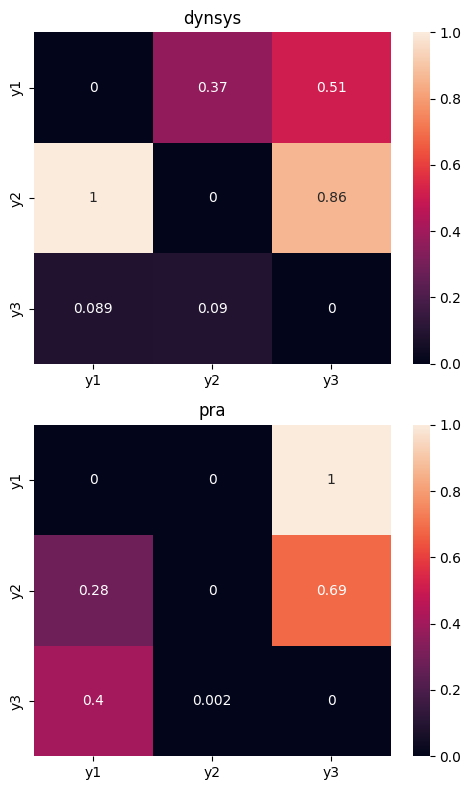

In [16]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5,8))
sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('dynsys')

sns.heatmap(pra_mat, annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('pra')

fig.tight_layout()
plt.savefig('heatmaps.png')

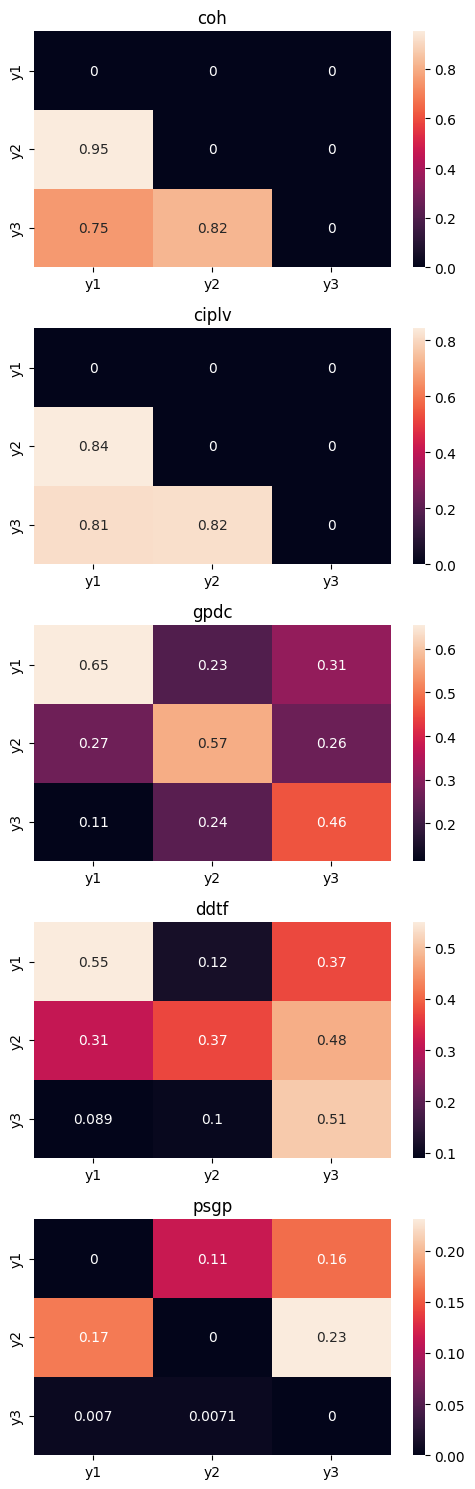

In [17]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(5,15))
sns.heatmap(coh_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('coh')

sns.heatmap(ciplv_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('ciplv')

sns.heatmap(gpdc_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax3)
ax3.set_title('gpdc')

sns.heatmap(ddtf_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax4)
ax4.set_title('ddtf')

sns.heatmap(psgp_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax5)
ax5.set_title('psgp')
fig.tight_layout()
plt.savefig('heatmaps.png')

#### Assessing all connections with mse

In [18]:
ground_truth = np.array([[0,0,1],[0,0,1],[0,0,0]])

mse_dynsys = np.sum((dynsys_mat - ground_truth)**2)/9
mse_pra = np.sum((pra_mat - ground_truth)**2)/9
mse_coh = np.sum((coh_mat.mean(2) - ground_truth)**2)/6
mse_ciplv = np.sum((ciplv_mat.mean(2) - ground_truth)**2)/6
mse_gpdc = np.sum((gpdc_mat.mean(2) - ground_truth)**2)/9
mse_ddtf = np.sum((ddtf_mat.mean(2) - ground_truth)**2)/9
mse_psgp = np.sum((psgp_mat.mean(2) - ground_truth)**2)/9

mse_dict = {'dynsys': mse_dynsys, 'pra':mse_pra, 'coh':mse_coh, 'ciplv':mse_ciplv, 'gpdc':mse_gpdc, 'ddtf':mse_ddtf,
            'psgp':mse_psgp}

In [19]:
sorted(mse_dict.items(), key=lambda x:x[1])

[('pra', 0.0378969254701792),
 ('psgp', 0.14879124694579757),
 ('dynsys', 0.15678033954802592),
 ('ddtf', 0.16607033288846154),
 ('gpdc', 0.2412514868495729),
 ('ciplv', 0.6720568214836861),
 ('coh', 0.6896386311917505)]

#### Assessing y1-y2 connection only

<BarContainer object of 8 artists>

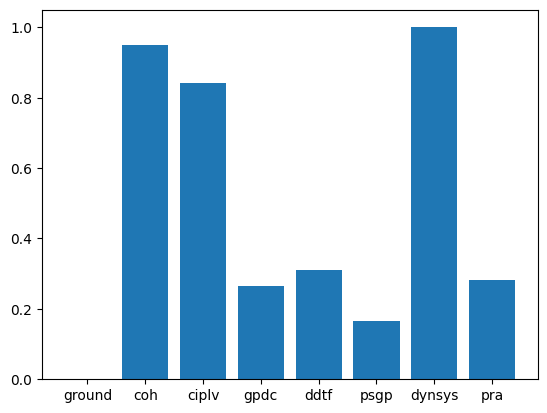

In [20]:
measures = ['ground', 'coh', 'ciplv', 'gpdc', 'ddtf', 'psgp', 'dynsys', 'pra']
y1_y2 = [0, coh_mat.mean(2)[1][0], ciplv_mat.mean(2)[1][0], gpdc_mat.mean(2)[1][0], ddtf_mat.mean(2)[1][0], psgp_mat.mean(2)[1][0],
        dynsys_mat.squeeze()[1][0], pra_mat.squeeze()[1][0]]
plt.bar(measures, y1_y2)

### Scenario 2B

In [21]:
y3 = signal3 + noise3*snr3 
y1 = signal1 + noise1*snr1 + c_3_1*np.roll(y3, lag1)
y2 = signal2 + noise2*snr2 + c_3_2*np.roll(y3, lag2) + c_1_2*np.roll(y1, lag3)

#### Simulated data and estimation

In [6]:
## simulated data
sim_data = np.array([y1,y2,y3])
info = mne.create_info(ch_names=["y1", "y2", "y3"], ch_types=["eeg"]*3, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=10)

## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)
dynsys_mat = (dynsys_mat - dynsys_mat.min())/(dynsys_mat.max() - dynsys_mat.min())

#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")
coh_mat = (coh_mat - coh_mat.min())/(coh_mat.max() - coh_mat.min())

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")
ciplv_mat = (ciplv_mat - ciplv_mat.min())/(ciplv_mat.max() - ciplv_mat.min())

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
gpdc_mat = (gpdc_mat - gpdc_mat.min())/(gpdc_mat.max() - gpdc_mat.min())

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
ddtf_mat = (ddtf_mat - ddtf_mat.min())/(ddtf_mat.max() - ddtf_mat.min())

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
psgp_mat = (psgp_mat - psgp_mat.min())/(psgp_mat.max() - psgp_mat.min())

#pra
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
pra_mat = pra.PRA(epochs.get_data(), epoch_idx, region, sampling_time=0.01)
pra_mat = (pra_mat - pra_mat.min())/(pra_mat.max() - pra_mat.min())

Using data from preloaded Raw for 10 events and 1000 original time points ...


  0%|          | 0/1 [00:00<?, ?it/s]

Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..9.990s for estimation (1000 points)
    frequencies: 8.0Hz..13.0Hz (51 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
  

Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged


Using data from preloaded Raw for 10 events and 1000 original time points ...


Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged


Using data from preloaded Raw for 10 events and 1000 original time points ...


Maximum iterations reached. 0 of 1 converged


Using data from preloaded Raw for 10 events and 1000 original time points ...


  0%|          | 0/10 [00:00<?, ?it/s]

#### Adjacency matrices

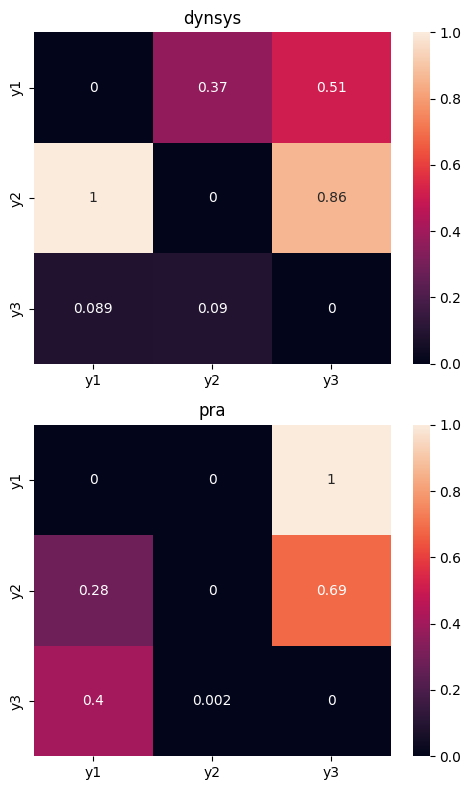

In [7]:
#heatmaps
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5,8))
sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('dynsys')

sns.heatmap(pra_mat, annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('pra')

fig.tight_layout()
plt.savefig('heatmaps.png')

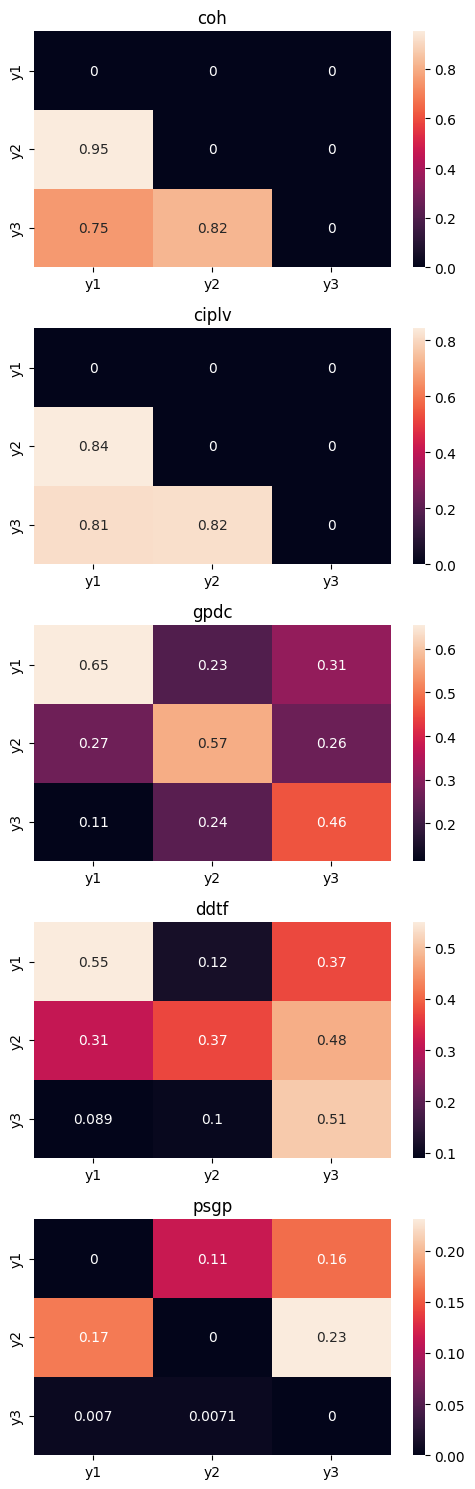

In [8]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(5,15))
sns.heatmap(coh_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax1)
ax1.set_title('coh')

sns.heatmap(ciplv_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax2)
ax2.set_title('ciplv')

sns.heatmap(gpdc_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax3)
ax3.set_title('gpdc')

sns.heatmap(ddtf_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax4)
ax4.set_title('ddtf')

sns.heatmap(psgp_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'], ax=ax5)
ax5.set_title('psgp')
fig.tight_layout()
plt.savefig('heatmaps.png')

#### Assessing all connections with mse

In [23]:
ground_truth = np.array([[0,0,1],[1,0,1],[0,0,0]])

mse_dynsys = np.sum((dynsys_mat - ground_truth)**2)/9
mse_pra = np.sum((pra_mat - ground_truth)**2)/9
mse_coh = np.sum((coh_mat.mean(2) - ground_truth)**2)/6
mse_ciplv = np.sum((ciplv_mat.mean(2) - ground_truth)**2)/6
mse_gpdc = np.sum((gpdc_mat.mean(2) - ground_truth)**2)/9
mse_ddtf = np.sum((ddtf_mat.mean(2) - ground_truth)**2)/9
mse_psgp = np.sum((psgp_mat.mean(2) - ground_truth)**2)/9

mse_dict = {'dynsys': mse_dynsys, 'pra':mse_pra, 'coh':mse_coh, 'ciplv':mse_ciplv, 'gpdc':mse_gpdc, 'ddtf':mse_ddtf,
            'psgp':mse_psgp}

In [24]:
sorted(mse_dict.items(), key=lambda x:x[1])

[('dynsys', 0.04566922843691481),
 ('pra', 0.0863428794392938),
 ('ddtf', 0.20826757780113245),
 ('psgp', 0.2229906805823341),
 ('gpdc', 0.29336998652778595),
 ('coh', 0.5393269343112278),
 ('ciplv', 0.5580989465686992)]

<BarContainer object of 8 artists>

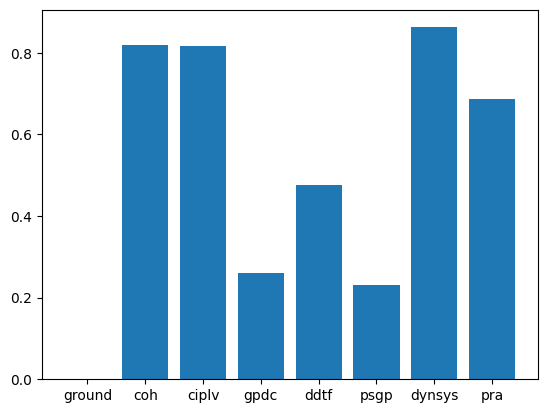

In [25]:
measures = ['ground', 'coh', 'ciplv', 'gpdc', 'ddtf', 'psgp', 'dynsys', 'pra']
y1_y2 = [0, coh_mat.mean(2)[2][1], ciplv_mat.mean(2)[2][1], gpdc_mat.mean(2)[1][2], ddtf_mat.mean(2)[1][2], psgp_mat.mean(2)[1][2],
        dynsys_mat.squeeze()[1][2], pra_mat.squeeze()[1][2]]
plt.bar(measures, y1_y2)